In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchprofile
from Dataloader import prepare_data_loader
from obspy import read
from scipy import signal
from matplotlib import cm
from datetime import timedelta
from Models import *
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
training_data_dir = "./data/lunar/training/data/S12_GradeA/"
training_labels_file = (
    "./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
)

train_loader = prepare_data_loader(
    overlap=0.25,
    window_length=1,
    decimation_factor=3,
    spect_nfft=128,
    spect_nperseg=128,
    batch_size=128,
    data_dir=training_data_dir,
    labels_file_path=training_labels_file,
)

Starting number of files: 76
Number of uniques files: 71
xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed
xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed
xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed
xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed
xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed
xa.s12.00.mhz.1970-06-15HR00_evid00008.mseed
xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed
xa.s12.00.mhz.1970-07-20HR00_evid00010.mseed
xa.s12.00.mhz.1970-09-26HR00_evid00013.mseed
xa.s12.00.mhz.1970-10-24HR00_evid00014.mseed
xa.s12.00.mhz.1970-11-12HR00_evid00015.mseed
xa.s12.00.mhz.1970-12-11HR00_evid00017.mseed
xa.s12.00.mhz.1970-12-27HR00_evid00019.mseed
xa.s12.00.mhz.1970-12-31HR00_evid00021.mseed
xa.s12.00.mhz.1971-01-15HR00_evid00022.mseed
xa.s12.00.mhz.1971-01-28HR00_evid00023.mseed
xa.s12.00.mhz.1971-01-29HR00_evid00024.mseed
xa.s12.00.mhz.1971-02-09HR00_evid00026.mseed
xa.s12.00.mhz.1971-03-25HR00_evid00028.mseed
xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed
xa.s12.00.mhz.1971-04-17HR00_evid00030.msee

In [4]:
height, width = train_loader.dataset.tensors[0].shape[1:]

In [42]:
hidden_size = 100
classifier = Classifier(hidden_size).to(device)
encoder = Encoder(hidden_size).to(device)
encoder.load_state_dict(torch.load("./models/encoder.pth", weights_only=False))

<All keys matched successfully>

epoch [1/150], loss: 35.061795473098755
epoch [2/150], loss: 32.38816648721695
epoch [3/150], loss: 29.065954625606537
epoch [4/150], loss: 25.313639640808105
epoch [5/150], loss: 21.531206279993057
epoch [6/150], loss: 18.722151279449463
epoch [7/150], loss: 16.523186773061752
epoch [8/150], loss: 15.245694890618324
epoch [9/150], loss: 14.030316919088364
epoch [10/150], loss: 13.696727693080902
epoch [11/150], loss: 12.348427534103394
epoch [12/150], loss: 12.247899174690247
epoch [13/150], loss: 12.153608590364456
epoch [14/150], loss: 12.004681125283241
epoch [15/150], loss: 12.01068140566349
epoch [16/150], loss: 11.46320490539074
epoch [17/150], loss: 11.393946826457977
epoch [18/150], loss: 11.05513770878315
epoch [19/150], loss: 10.570895403623581
epoch [20/150], loss: 10.105033792555332
epoch [21/150], loss: 10.863134786486626
epoch [22/150], loss: 10.523918628692627
epoch [23/150], loss: 10.267622083425522
epoch [24/150], loss: 10.523756355047226
epoch [25/150], loss: 9.79156

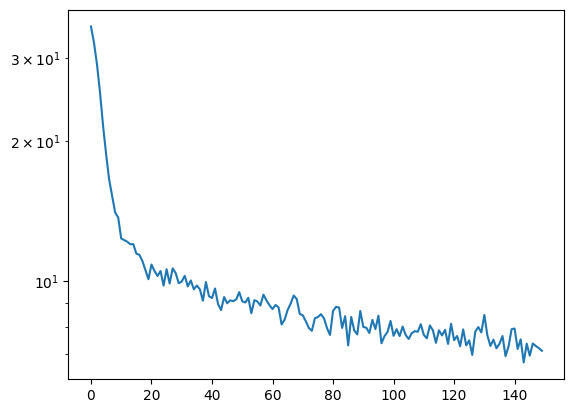

In [43]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.BCELoss()

num_epochs = 150
all_losses = []
classifier.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for x, y, _ in train_loader:
        x = x.reshape(-1, 1, height, width).to(device)
        y = y.float().to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        preds = preds.view(-1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    print(f"epoch [{epoch + 1}/{num_epochs}], loss: {epoch_loss}")
    all_losses.append(epoch_loss)

# torch.save(classifier, './models/classifier.pth')
plt.plot(all_losses)
plt.yscale("log")
plt.show()

In [56]:
# torch.save(classifier, './models/classifier.pth')
# state_dict = torch.load('./models/classifier.pth', map_location=device, weights_only=False)
# classifier.load_state_dict(state_dict.state_dict())

In [45]:
dummy_input = torch.randn(1, 1, height, width).to(device)

encoder_flops = torchprofile.profile_macs(encoder, dummy_input)
embedding = encoder(dummy_input)
embedding = embedding.view(embedding.size(0), -1)
classifier_flops = torchprofile.profile_macs(classifier, embedding)
total_flops = encoder_flops + classifier_flops

print(f"Encoder: {encoder_flops} FLOPS")
print(f"Classifier: {classifier_flops} FLOPS")
print(f"Total: {total_flops} FLOPS")

Encoder: 403968 FLOPS
Classifier: 6275 FLOPS
Total: 410243 FLOPS


c:\Users\wpietron\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchprofile\profile.py:22: UserWarning: No handlers found: "aten::reshape". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [46]:
def calculate_memory_requirements(model, input_size):
    num_params = sum(p.numel() for p in model.parameters())
    param_memory = num_params * 4  # 32-bit (4 bytes) precision
    dummy_input = torch.randn(input_size).to(device)
    activations = []

    def hook(module, input, output):
        activations.append(output)

    hooks = []
    for layer in model.children():
        hooks.append(layer.register_forward_hook(hook))
    model(dummy_input)
    activation_memory = sum(a.numel() * 4 for a in activations)
    gradient_memory = activation_memory
    total_memory = param_memory + activation_memory + gradient_memory
    total_memory_mb = total_memory / (1024**2)
    for hook in hooks:
        hook.remove()
    return total_memory_mb


input_size = (1, 1, height, width)
encoder_memory = calculate_memory_requirements(encoder, input_size)
classifier_memory = calculate_memory_requirements(classifier, (1, 100))

total_memory_mb = encoder_memory + classifier_memory
print(f"Total RAM required: {total_memory_mb:.2f} MB")

Total RAM required: 0.47 MB


In [47]:
thr_loader = torch.utils.data.DataLoader(train_loader.dataset.tensors[0], batch_size=1)
classifier.eval()
preds_list = []
with torch.no_grad():
    for x in thr_loader:
        x = x.reshape(-1, 1, height, width).to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        preds = preds.view(-1)
        preds_list.append(preds.item())
preds_list = torch.tensor(preds_list)

In [48]:
max_fscore = 0
for thr in range(1, 100):
    threshold = thr / 100
    preds = preds_list > threshold
    true_positives = (preds & train_loader.dataset.tensors[1].bool()).sum().item()
    false_positives = (preds & ~train_loader.dataset.tensors[1].bool()).sum().item()
    false_negatives = (~preds & train_loader.dataset.tensors[1].bool()).sum().item()
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    fscore = 2 * precision * recall / (precision + recall)
    if max_fscore < fscore:
        max_fscore = fscore
        best_thr = threshold
print(f"Threshold: {best_thr}, Fscore: {max_fscore:.2f}")

Threshold: 0.8, Fscore: 0.90


In [49]:
test_data_dir = "./data/lunar/test/data/S12_GradeB/"
# test_data_dir = './data/lunar/test/data/S15_GradeA/'

spctrs, enc_dates = prepare_data_loader(
    overlap=0.25,
    window_length=1,
    decimation_factor=3,
    spect_nfft=128,
    spect_nperseg=128,
    batch_size=128,
    data_dir=test_data_dir,
    one_file=True,
)

Starting number of files: 64
Number of uniques files: 62
xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed
xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed
xa.s12.00.mhz.1970-02-07HR00_evid00014.mseed
xa.s12.00.mhz.1970-02-18HR00_evid00016.mseed
xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed
xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed
xa.s12.00.mhz.1970-04-03HR00_evid00021.mseed
xa.s12.00.mhz.1970-05-20HR00_evid00026.mseed
xa.s12.00.mhz.1970-05-23HR00_evid00027.mseed
xa.s12.00.mhz.1970-05-24HR00_evid00028.mseed
xa.s12.00.mhz.1970-05-25HR00_evid00029.mseed
xa.s12.00.mhz.1970-06-19HR00_evid00031.mseed
xa.s12.00.mhz.1970-07-17HR00_evid00035.mseed
xa.s12.00.mhz.1970-07-18HR00_evid00036.mseed
xa.s12.00.mhz.1970-07-20HR00_evid00037.mseed
xa.s12.00.mhz.1970-07-27HR00_evid00039.mseed
xa.s12.00.mhz.1970-09-09HR00_evid00043.mseed
xa.s12.00.mhz.1970-10-26HR00_evid00049.mseed
xa.s12.00.mhz.1970-11-03HR00_evid00050.mseed
xa.s12.00.mhz.1971-01-03HR00_evid00057.mseed
xa.s12.00.mhz.1971-01-05HR00_evid00059.msee

In [50]:
testset = torch.utils.data.TensorDataset(torch.tensor(spctrs))
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [51]:
dates = [date[0].strftime("%Y-%m-%d %H:%M:%S") for date in enc_dates]

In [52]:
date_to_pred, date_to_spc = {}, {}
classifier.eval()
with torch.no_grad():
    for i, spc in enumerate(test_loader):
        x = spc[0].float().reshape(-1, 1, height, width).to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        date_to_pred[dates[i]] = preds.item() > best_thr
        date_to_spc[dates[i]] = spc[0]

In [53]:
num_file = 5
for i, file in enumerate(os.listdir(test_data_dir)):
    if file.endswith(".mseed"):
        if i // 2 == num_file:
            print(file)
            mseed_file = f"{test_data_dir}{file}"
            st = read(mseed_file)
            break

xa.s12.00.mhz.1970-03-30HR00_evid00020.mseed


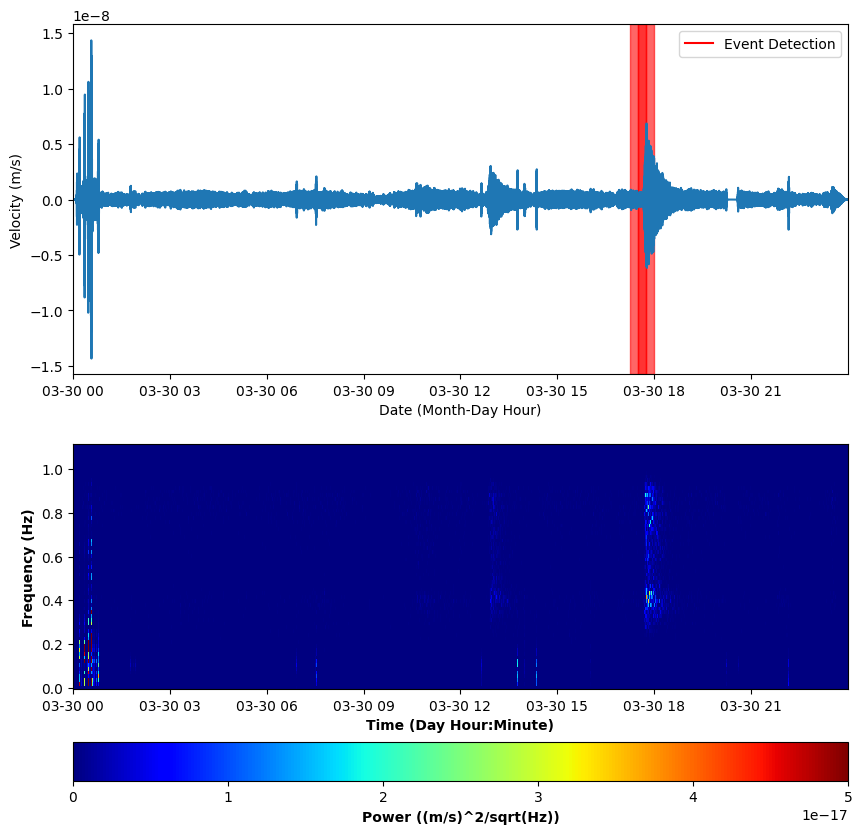

In [55]:
tr = st.traces[0].copy()
start_time = st[0].stats.starttime.datetime
sampling_rate = st[0].stats.sampling_rate
tr_data = tr.data
tr_times = tr.times()

# print(sampling_rate)
tr_data = tr.data
starttime = tr.stats.starttime.datetime
endtime = tr.stats.endtime.datetime
time_diff = int((endtime - starttime).total_seconds() / 3600)

tmp_data_undersample = signal.decimate(tr_data, 3, axis=0, zero_phase=True)
f, t, sxx = signal.spectrogram(
    tmp_data_undersample, sampling_rate / 3, nperseg=128, nfft=128
)
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(2, 1, 1)
ax.plot(tr_times, tr_data)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xticks([min(tr_times) + i * 3600 for i in range(0, time_diff + 1, 3)])
ax.set_xticklabels(
    [
        (starttime + timedelta(hours=i)).strftime("%m-%d %H")
        for i in range(0, time_diff + 1, 3)
    ]
)

filterer = {}
for i in range(4 * time_diff + 4):
    time = starttime + timedelta(minutes=15 * i)
    filterer[(time - starttime).total_seconds()] = 0

for i in range(4 * time_diff + 1):
    time = starttime + timedelta(minutes=15 * i)
    if date_to_pred.get(time.strftime("%Y-%m-%d %H:%M:%S"), False):
        # print(time.strftime('%Y-%m-%d %H:%M:%S'))
        t_label = (time - starttime).total_seconds()
        for j in range(4):
            filterer[t_label + 900 * j] += 1
i = 0
low = 2
while i < 4 * time_diff + 1:
    time = starttime + timedelta(minutes=15 * i)
    t_label = (time - starttime).total_seconds()
    length = 1
    if filterer[t_label] > low:
        while filterer[t_label + length * 900] > low:
            if filterer[t_label + length * 900] != filterer[t_label]:
                break
            length += 1
        ax.axvspan(
            t_label, t_label + length * 900, color="red", alpha=0.2 * filterer[t_label]
        )
    i += length

# add legend
ax.plot([], [], color="red", alpha=1.0, label="Event Detection")
ax.legend()

ax.set_ylabel("Velocity (m/s)")
ax.set_xlabel("Date (Month-Day Hour)")

ax2 = plt.subplot(2, 1, 2)
ax2.sharex(ax)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlabel(f"Time (Day Hour:Minute)", fontweight="bold")
ax2.set_ylabel("Frequency (Hz)", fontweight="bold")
cbar = plt.colorbar(vals, orientation="horizontal")
cbar.set_label("Power ((m/s)^2/sqrt(Hz))", fontweight="bold")